In [1]:
import tensorflow as tf
from resizeimage import resizeimage
from PIL import Image, ImageOps
import numpy as np
import cv2

In [3]:
CLASS_NAMES_WITHOUT_DISGUST = ["Angry", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [15]:
CNNModel6 = tf.keras.models.load_model("C:/Users/Xander/Downloads/CNNModel6")
CNNModel4 = tf.keras.models.load_model("C:/Users/Xander/Downloads/CNNmodel4")
CNNModel5 = tf.keras.models.load_model("C:/Users/Xander/Downloads/CNNmodel5")

import joblib
randomForestModel = joblib.load("RandomForest-Augmented9-Oversampled-Accuracy83.66.joblib")

In [5]:
def predict(image):
    rgb_image = cv2.cvtColor(np.float32(image), cv2.COLOR_GRAY2RGB)
    rgb_image = rgb_image.reshape(1, 48, 48, 3)
    image = image.reshape(1, 48, 48, 1)
    
    CNNModel4_predictions = CNNModel4.predict(image)
    CNNModel5_predictions = CNNModel5.predict(image)
    
    CNNModel6_predictions = CNNModel6.predict(rgb_image) # This transfer learning model expects rgb input
    
    return CNNModel4_predictions, CNNModel5_predictions, CNNModel6_predictions
    

def preprocess_image(image):
    image = resizeimage.resize_cover(image, [48,48])
    image = ImageOps.grayscale(image)
    image = np.array(image)
    image = image.astype("int32")
    image = image/255.0
    image = image.reshape(48, 48, 1)
    return image

In [6]:
def import_test_sample(test_path):
    with open(test_path, 'r+b') as f:
        with Image.open(f) as image:
            test_image = resizeimage.resize_cover(image, [48,48])
    return test_image

In [20]:
def predictCombined(predictions):
    y_pred = np.array([0,0,0,0,0,0])
    
    for prediction in predictions:
        y_pred = y_pred + np.array(prediction)
    return y_pred

In [16]:
#pip install opencv-python
import cv2
import time

def click_and_crop(event, x, y, flags, param):
    global refPt, cropping
    # if the left mouse button was clicked, record the starting
    # (x, y) coordinates and indicate that cropping is being
    # performed
    if event == cv2.EVENT_LBUTTONDOWN:
        refPt = [(x, y)]
        cropping = True
        # check to see if the left mouse button was released
    elif event == cv2.EVENT_LBUTTONUP:
        # record the ending (x, y) coordinates and indicate that
        # the cropping operation is finished
        refPt.append((x, y))
        cropping = False
        # draw a rectangle around the region of interest
        #cv2.rectangle(image, refPt[0], refPt[1], (0, 255, 0), 2)
        #cv2.imshow("my webcam", image)

Predicted emotion:
 Sad


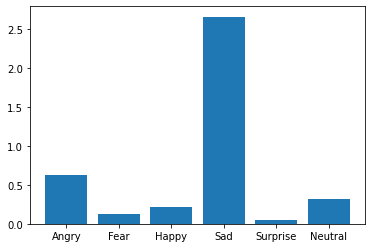

In [22]:
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
%matplotlib inline

refPt = []
cam = cv2.VideoCapture(0) # Put here another number for another cam
if cam.isOpened():  # try to get the first frame
    print('Cam is found')
else:
    print("Cam is not found")

while True:
    ret_val, img = cam.read()
    if ret_val == False:
        cam.release()
        print("Cam is not working correctly")
    if cv2.waitKey(1) == 27: 
        break  # esc to quit
    if len(refPt) == 2:
        roi = img[refPt[0][1]:refPt[1][1], refPt[0][0]:refPt[1][0]]
        cv2.imshow("Cropped Webcam", roi)
        
        test_image = cv2.resize(roi, [48,48])
        test_image = Image.fromarray(test_image)
        test_image = ImageOps.grayscale(test_image)

        image1 = preprocess_image(test_image)
        CNNModel4_predictions, CNNModel5_predictions, CNNModel6_predictions = predict(image1)

        predictions = [CNNModel4_predictions, CNNModel5_predictions, CNNModel6_predictions]

        test_image = ImageOps.grayscale(test_image)

        test_image = np.array(test_image)
        test_image = test_image.astype("int32")
        test_image = test_image/255.0
        test_image = test_image.reshape(48, 48, 1)

        predictions.append(randomForestModel.predict_proba(np.reshape(test_image, (1, 2304)))[0])
            
        y_pred = predictCombined(predictions)
        
        clear_output(wait=True)
        
        print("Predicted emotion:\n", CLASS_NAMES_WITHOUT_DISGUST[np.argmax(y_pred[0])])
        
        plt.bar(CLASS_NAMES_WITHOUT_DISGUST, y_pred[0])
        plt.show()

    else:
        cv2.imshow('Webcam (not cropped)', img)
        cv2.setMouseCallback("Webcam (not cropped)", click_and_crop)

cv2.destroyAllWindows()